**Rithesh Kumar** \\
**Sai Krishna** \\

Assignment-3: Track1: Dyna-Q

**Experience replay:** 
* It is a method to speed up the credit propagation process and/or to shorten the trial and error process.
* An "experience" is a quadraple (s,a,s',r).
* A "lesson" is a temporal sequence of experiences starting from an initial state to a final state, where the goal may or may not be acheived. Here, our agent simply remembers its past experiences and repeatedly presents the experiences to the algorithm as if the agent had experienced it again and again. As a result, the process of credit/blame propagation is sped up and hence networks converge more quickly. \\

**Dyna-Q:** \\
Dyna-Q includes all of the processes: planning, acting, model-learning and direct RL- all occurring continually. \\
* The planning method is the random-sample one-step tabular Q-planning method. \\
* The direct RL method is one step tabular Q-learning. \\

The model-learning method is also table-based and assumes that the world is deterministic. After each transition $S_t$, $A_t$ --> $R_{t+1}$, $S_{t+1}$, the model records in its table entries in the corresponding cell. So, if the model is queried with a state-action pair that has been experienced before, it simply returns the last-observed next state and next reward as its prediction. \\
During planning, the Q-planning algorithm randomly samples only from state-action pairs that have previously been experienced, so the model is never queried with a pair about which it has no information. \\

**Relation between Experience Replay and Model in Dyna-Q**:
* In experience replay, we keep track of (s, a, r, s') for places that are visited.
* When a model is being learnt using tabular method in deterministic environment, P(s', r| s, a) becomes a tabular entry of T[s, a] = s', r, which is exactly the same as the experience replay paradigm.

**Key learnings from the assignment:** \\
* We got different results when we run the same experiment with same hyperparameters. This led us to believe that initialization plays a key role in most RL algorithms. \\
* We initially ran our experiments with $\epsilon$ = 0.1, but it failed to converge for blocking_maze_two, probably indicating the lack of enough exploration. \\
* We then ran our experiments with $\epsilon$ = 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5. But, in failed to obtain a true balance between exploration and exploitation in all of these cases. \\
* So, we used a schedule for $\epsilon$ starting with $\epsilon$ = 0.5 for 500 steps and reducing it to $\epsilon$ = 0.1 for the rest of the timesteps, along with the learning rate alpha set to 1.
* In general, for small grid worlds like this, $\alpha$ = 0.1 and $\gamma$ = 0.95 are decent choices to make

In [2]:
! pip install git+https://github.com/deepmind/pycolab.git

  Cloning https://github.com/deepmind/pycolab.git to /tmp/pip-X45Zpl-build
  Running setup.py install for pycolab ... - done


In [0]:
import numpy as np
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
BLOCKING_MAZE_ONE = ['###########',
                     '#         #',
                     '#         #',
                     '#         #',
                     '######### #',
                     '#         #',
                     '#   P     #',
                     '###########',
                     ]

BLOCKING_MAZE_TWO = ['###########',
                     '#         #',
                     '#         #',
                     '#         #',
                     '# #########',
                     '#         #',
                     '#   P     #',
                     '###########',
                     ]

SHORTCUT_MAZE_ONE = ['###########',
                     '#         #',
                     '#         #',
                     '#         #',
                     '# #########',
                     '#         #',
                     '#   P     #',
                     '###########',
                     ]

SHORTCUT_MAZE_TWO = ['###########',
                     '#         #',
                     '#         #',
                     '#         #',
                     '# ####### #',
                     '#         #',
                     '#   P     #',
                     '###########',
                     ]


class PlayerSprite(prefab_sprites.MazeWalker):
    def __init__(self, corner, position, character):
        """Inform superclass that we can't walk through walls."""
        super(PlayerSprite, self).__init__(
            corner, position, character, impassable='#')

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things  # Unused

        # Apply motion commands.
        if actions == 0:  # walk up
            self._north(board, the_plot)
        elif actions == 1:  # walk down
            self._south(board, the_plot)
        elif actions == 2:  # walk left
            self._west(board, the_plot)
        elif actions == 3:  # walk right
            self._east(board, the_plot)

        # See if we've found the goal spot.
        if self.position == (1, 9):
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()
        else:
            the_plot.add_reward(0)


def make_game(GAME_ART):
    return ascii_art.ascii_art_to_game(
        GAME_ART, what_lies_beneath=' ',
        sprites={'P': PlayerSprite})


class Env(object):
    def __init__(self, game_art_start, game_art_end, cliff=3000):
        self.timesteps = 0
        self.cliff = cliff
        self.game_art_start = game_art_start
        self.game_art_end = game_art_end
        self.reset()

    def reset(self):
        art = self.game_art_start if self.timesteps <= self.cliff else self.game_art_end
        self.game = ascii_art.ascii_art_to_game(
            art, what_lies_beneath=' ',
            sprites={'P': PlayerSprite}
        )
        obs, reward, terminal = self.game.its_showtime()
        state = np.asarray(obs.layers['P'], dtype='int')
        state = ''.join(map(str, state.flatten().tolist()))
        return state, reward, terminal == 0

    def step(self, action):
        self.timesteps += 1
        obs, reward, terminal = self.game.play(action)
        state = np.asarray(obs.layers['P'], dtype='int')
        state = ''.join(map(str, state.flatten().tolist()))
        return state, reward, terminal == 0


class DynaQ(object):
    def __init__(self, n_actions=4):
        self.n_actions = n_actions
        self.Model = {}
        self.Q = {}
        
        # Hyperparameters
        self.alpha = 1
        self.epsilon = 0.1
        self.gamma = 0.95

    def update_model(self, s, a, r, s_dash):
        if s in self.Model:
            if not type(self.Model[s]) == dict:
                self.Model[s] = {}
            self.Model[s][a] = (r, s_dash)
        else:
            self.Model[s] = {a: (r, s_dash)}

    def sample_model(self):
        s = np.random.choice(self.Model.keys())
        a = np.random.choice(self.Model[s].keys())
        r, s_dash = self.Model[s][a]
        return s, a, r, s_dash
      
    def update_q(self, s, a, r, s_dash):
        if s_dash not in self.Q:
            self.Q[s_dash] = np.zeros(self.n_actions)
          
        self.Q[s][a] += self.alpha * (r + self.gamma * self.Q[s_dash].max() - self.Q[s][a])

    def sample_q(self, s):
        if s not in self.Q:
            self.Q[s] = np.zeros(self.n_actions)

        if np.random.rand() < self.epsilon:
            a = np.random.choice(self.n_actions)
        else:
            a = np.random.choice(np.flatnonzero(self.Q[s] == self.Q[s].max()))

        return a

      
def learn(maze_one, maze_two, cliff, n_steps=6000, n_imaginations=50):
    alg = DynaQ()
    env = Env(maze_one, maze_two, cliff)
    epsilon_schedule = [.5]*500 + [.1]* 5500

    s, _, _ = env.reset()
    rewards = []
    for i in xrange(n_steps):
        alg.epsilon = epsilon_schedule[i]
        a = alg.sample_q(s)
        s_dash, r, terminal = env.step(a)
        alg.update_q(s, a, r, s_dash)
        alg.update_model(s, a, r, s_dash)
        
        rewards.append(r)
        
        for j in xrange(n_imaginations):
            experience = alg.sample_model()
            alg.update_q(*experience)

        if terminal == True:
            s, _, _ = env.reset()
        else:
            s = s_dash
    return rewards    

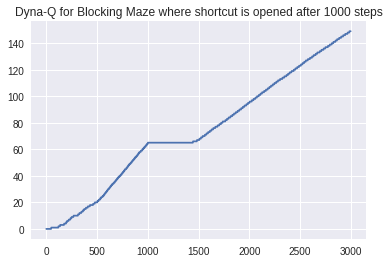

In [51]:
arr = learn(BLOCKING_MAZE_ONE, BLOCKING_MAZE_TWO, 1000, n_steps=3000)
plt.plot(np.cumsum(arr))
_ = plt.title("Dyna-Q for Blocking Maze where shortcut is opened after 1000 steps")

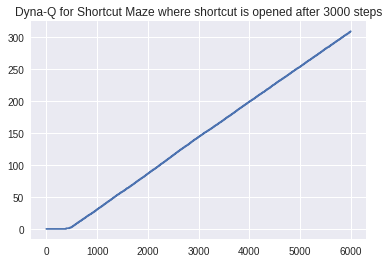

In [53]:
arr = learn(SHORTCUT_MAZE_ONE, SHORTCUT_MAZE_TWO, 3000)
plt.plot(np.cumsum(arr))
_ = plt.title("Dyna-Q for Shortcut Maze where shortcut is opened after 3000 steps")